<a href="https://colab.research.google.com/github/sulaimangm/SEP769_CPS_DeepLearning/blob/main/SEP769_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Kaggle

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


# Import and Extract Dataset

In [2]:
# Download the wildfire prediction dataset
!kaggle datasets download -d garystafford/environmental-sensor-data-132k

# Unzip the downloaded dataset
!unzip environmental-sensor-data-132k.zip

 74% 5.00M/6.74M [00:00<00:00, 43.2MB/s]
100% 6.74M/6.74M [00:00<00:00, 53.3MB/s]
Archive:  environmental-sensor-data-132k.zip
  inflating: iot_telemetry_data.csv  


In [3]:
import zipfile

# Set the path to the zip file
zip_file_path = '/content/environmental-sensor-data-132k.zip'

# Set the path to the directory where the contents of the zip file will be extracted
extract_path = '/content/environmental-sensor-data-132k'

# Extract the contents of the zip file to the extract directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Import Libraries

In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dataset Pre Processing

In [5]:
dataset_path = '/content/iot_telemetry_data.csv'
df = pd.read_csv(dataset_path)
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


## Encoding device and Light Values

In [6]:
columns_to_encode = ['device', 'light']
encoder = LabelEncoder()
encoded_df = df.copy()
encoded_df[columns_to_encode] = encoded_df[columns_to_encode].apply(lambda col: encoder.fit_transform(col))
encoded_df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,2,0.004956,51.000000,0,0.007651,False,0.020411,22.700000
1,1.594512e+09,0,0.002840,76.000000,0,0.005114,False,0.013275,19.700001
2,1.594512e+09,2,0.004976,50.900000,0,0.007673,False,0.020475,22.600000
3,1.594512e+09,1,0.004403,76.800003,1,0.007023,False,0.018628,27.000000
4,1.594512e+09,2,0.004967,50.900000,0,0.007664,False,0.020448,22.600000


## Dropping Unwanted columns

In [8]:
classes = encoded_df['device']
cleaned_df = encoded_df.drop(columns=['ts', 'motion', 'device'])
cleaned_df.head()

,co,humidity,light,lpg,smoke,temp
0,0.004956,51.000000,0,0.007651,0.020411,22.700000
1,0.002840,76.000000,0,0.005114,0.013275,19.700001
2,0.004976,50.900000,0,0.007673,0.020475,22.600000
3,0.004403,76.800003,1,0.007023,0.018628,27.000000
4,0.004967,50.900000,0,0.007664,0.020448,22.600000


## Scaling Data


In [9]:
columns_to_scale = ['co', 'humidity', 'lpg', 'smoke', 'temp']
scaler = StandardScaler()
scaled_df = cleaned_df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(scaled_df[columns_to_scale])
scaled_df.head()

,co,humidity,light,lpg,smoke,temp
0,0.253670,-0.836820,0,0.286471,0.280867,0.091172
1,-1.438976,1.362631,0,-1.469927,-1.465637,-1.020621
2,0.269729,-0.845618,0,0.301986,0.296495,0.054112
3,-0.188651,1.433013,1,-0.148041,-0.155499,1.684742
4,0.262810,-0.845618,0,0.295303,0.289763,0.054112


In [10]:
classes

0         2
1         0
2         2
3         1
4         2
         ..
405179    0
405180    2
405181    1
405182    0
405183    2
Name: device, Length: 405184, dtype: int64

# Train-Test Split

In [11]:
XTrain,XTest,XcTrain,XcTest=train_test_split(scaled_df,classes,test_size=0.25)

# Classification Using K Nearest Neighbours

## Performing Classification Without Tuning Parameters

In [12]:
knnNonTune = KNeighborsClassifier()
knnNonTune.fit(XTrain,XcTrain)

KNeighborsClassifier()

In [13]:
prediction = knnNonTune.predict(XTest)
test_accuracy = accuracy_score(XcTest, prediction)
print("The Accuracy on the Test Set is ", test_accuracy)

0.9999802558837466

## Performing K-Fold Cross Validation with Parameter Selection using Grid-Search

In [16]:
kList = list(range(1,50))
knn = KNeighborsClassifier()
params = {'n_neighbors' : kList}
grid_kn = GridSearchCV(estimator = knn, param_grid = params, scoring = 'accuracy', cv = 10, verbose = 1, n_jobs=-1)
grid_kn.fit(XTrain, XcTrain)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=1)

In [17]:
prediction = grid_kn.predict(XTest)
test_accuracy = accuracy_score(XcTest, prediction)
print("The Accuracy on the Test Set is ", test_accuracy)

The Accuracy on the Test Set is  0.9999802558837466


## Plotting the graph of no. of Neighbours vs Accuracy

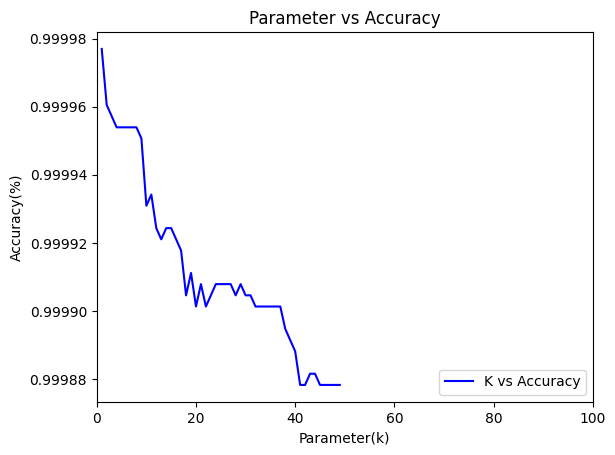

In [18]:
plt.title('Parameter vs Accuracy')
plt.plot(kList, grid_kn.cv_results_['mean_test_score'], 'b', label = 'K vs Accuracy')
plt.legend(loc = 'lower right')
plt.xlim([0, 100])
plt.ylabel('Accuracy(%)')
plt.xlabel('Parameter(k)')
plt.show()

In [21]:
conf_matrix = confusion_matrix(XcTest, prediction)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[27912     1     1]
 [    0 26537     0]
 [    0     0 46845]]


In [23]:
report = classification_report(XcTest, prediction)
print("Cllasification Report:")
print(report)

Cllasification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27914
           1       1.00      1.00      1.00     26537
           2       1.00      1.00      1.00     46845

    accuracy                           1.00    101296
   macro avg       1.00      1.00      1.00    101296
weighted avg       1.00      1.00      1.00    101296



# Classification Using Random Forest